## Machine Learning Coursework (Part 1)

For the coursework, please make sure to implement your own code and not use libraries (except where explicitly asked). You will need to present your own code that performs nested cross-validation and the k-nearest neighbour algorithm, build confusion matrices, and estimate distances between data samples.

The purpose of this coursework is to help you:

- Get familiar with **common python modules / functions** used for ML in python
- Get practical experience **implementing** ML methods in python
- Get practical experience regarding **parameter selection** for ML methods
- Get practical experience on **evaluating** ML methods and applying cross-validation

Notes:

- don't use libraries that implement kNN or cross-validation. We want to see your code!
- Remember to comment all of your code (see here for tips: https://stackabuse.com/commenting-python-code/). You can also make use of Jupyter Markdown, where appropriate, to improve the layout of your code and documentation.
- Please add docstrings to all of your functions (so that users can get information on inputs/outputs and what each function does by typing SHIFT+TAB over the function name. For more detail on python docstrings, see here: https://numpydoc.readthedocs.io/en/latest/format.html)
- When a question allows a free-form answer (e.g. what do you observe?), create a new markdown cell below and answer the question in the notebook.
- Always save your notebook when you are done (this is not automatic)!
- Upload your completed notebook using the VLE

Plagiarism: please make sure that the material you submit has been created by you. Any sources you use for code should be properly referenced. Your code will be checked for plagiarism using appropriate software.

### Marking

The grades in this coursework are allocated approximately as follows:

|                                                    | mark   |
| -------------------------------------------------- | ------ |
| Data exploration (+ 2 questions)                   | 10     |
| Code, docu. & comments (KNN + Evaluation + NCV)    | 10     |
| Results (KNN folds + Summary + Confusion matrices) | 10     |
| Final questions:                                   | 10     |
| Overall quality & use of Markdown                  | 10     |
| Total available                                    | **50** |


## 1. Exploratory Data Analysis

In this coursework we are going to be working with the **Wine** dataset. This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features for you to work with.


In [1]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
#print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names)
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

In [2]:
# create the random_seed to be used for reproducibility
r = 42


### 1.1. Visualising the data

The first part of tackling any ML problem is visualising the data in order to understand some of the properties of the problem at hand. When there are only a small number of classes and features, it is possible to use scatter plots to visualise interactions between different pairings of features.

The following image shows what such a visualisation might look like on the Iris dataset that you worked on during the Topic exercises.

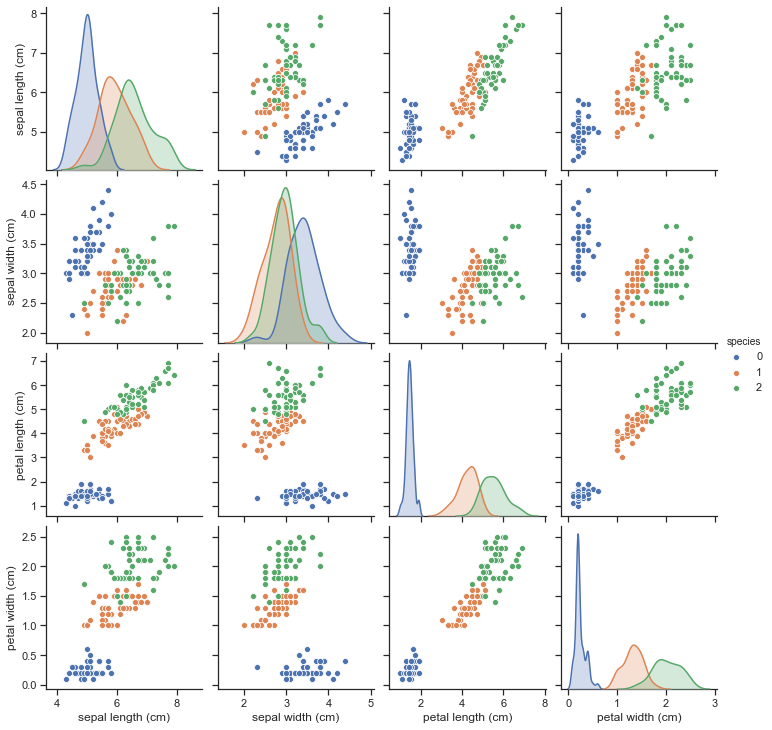

Your first task is to recreate a similar grid for the **Wine** dataset, with each off-diagonal subplot showing the interaction between two features, and each of the classes represented as a different colour. The on-diagonal subplots (representing a single feature) should show a distribution (or histogram) for that feature.

You should create a function that, given data X and labels y, plots this grid. The function should be invoked something like this:

    myplotGrid(X,y,...)

where X is your training data and y are the labels (you may also supply additional optional arguments). You can use an appropriate library to help you create the visualisation. You might want to code it yourself using matplotlib functions scatter and hist - however, this is not strictly necessary here, so try not spend too much time on this.


In [3]:
from typing import List
import numpy as np
import pandas as pd
import seaborn as sns


def myplotGrid(
    X: np.ndarray,
    y: np.ndarray,
    feature_names: List[str],
):
    """
    Plot pairwise relationships in a dataset with a kde diagonal
    and scatter non-diagonal pairwise combination, coloured by
    the target `y`.
    """
    df = pd.concat([pd.DataFrame(X), pd.Series(y)], axis=1)
    df.columns = feature_names + ["target"]
    g = sns.pairplot(df, hue="target", kind="scatter", diag_kind="kde")
    return g


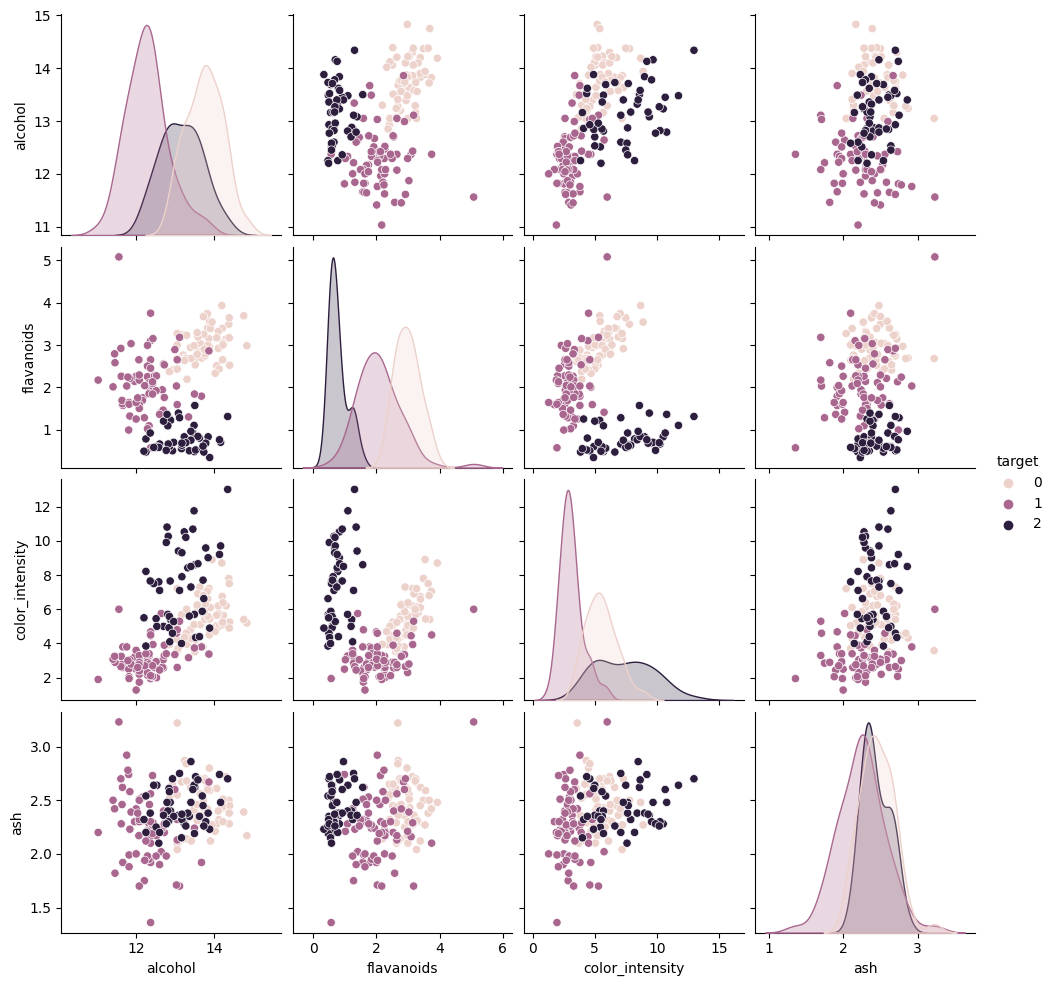

In [4]:
myplotGrid(X, y, feature_names=selected_features)


In [5]:
np.random.seed(r)
XN = X + np.random.normal(0, 0.6, X.shape)


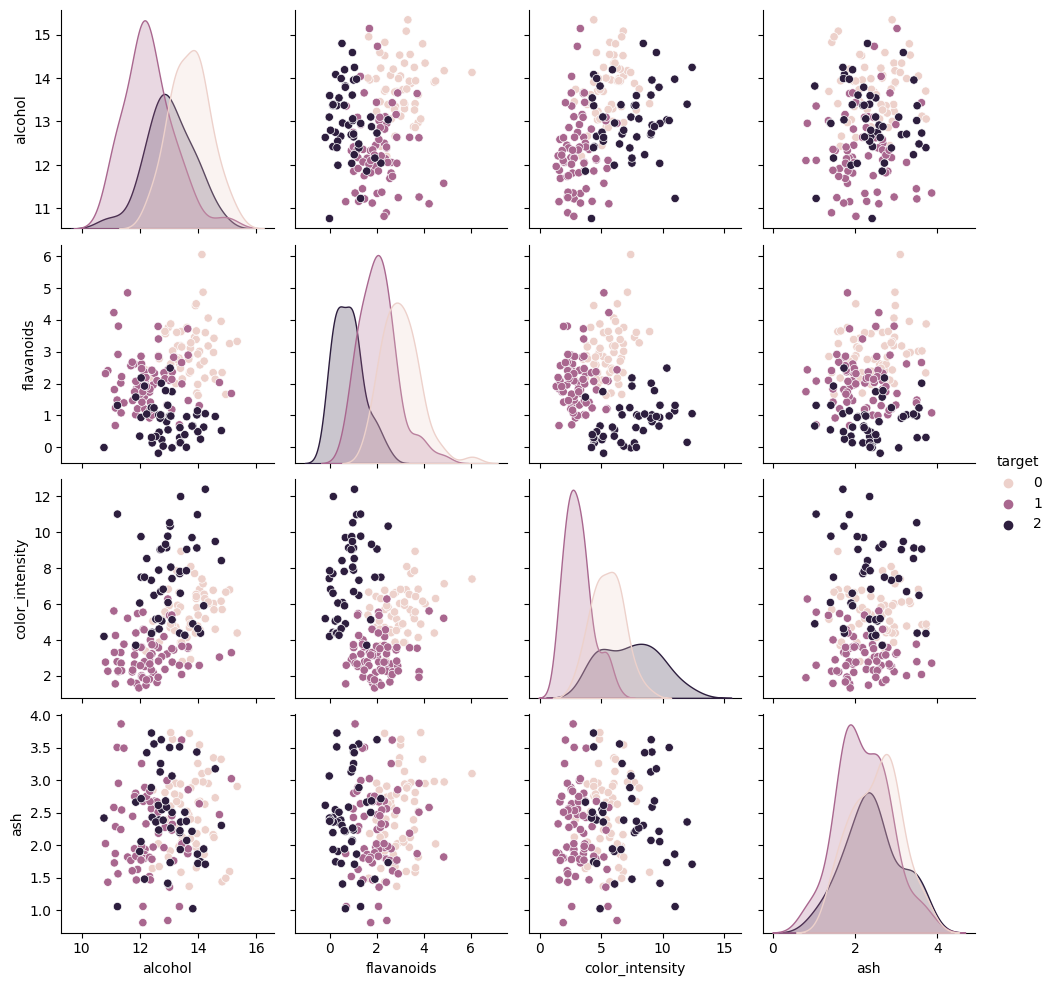

In [6]:
myplotGrid(XN, y, feature_names=selected_features)


### Q1. Exploratory data analysis

Based on your exploratory analysis, if you were to build a classifier using only two of the available features, which ones would you choose and why? Answer as fully as you can.


**Answer:**

> The features would be `color_intensity` and `flavanoids`.
>
> Features with strong correlation (`r-score` closer to either $-1$ or to $+1$) deliver similar signals, because their rate of change is similar. So the criteria for the choice should be the pair of features with `r-score` closer to $0$.


In [7]:
pd.DataFrame(X, columns=selected_features).corr()


,alcohol,flavanoids,color_intensity,ash
alcohol,1.000000,0.236815,0.546364,0.211545
flavanoids,0.236815,1.000000,-0.172379,0.115077
color_intensity,0.546364,-0.172379,1.000000,0.258887
ash,0.211545,0.115077,0.258887,1.000000


### Q2. Data with noise

What do you observe by plotting the data without noise compared to plotting with added Gaussian noise?


**Answer:**

> Apart from `flavanoids`, adding noise brought the distributions of
> all other features **closer to the normal distribution**, which can be observed
> through their **skew score** that ranges from $[-1,+1]$, with the **normal distribution**
> having **skew score** $0$.
> 
> The **kurtosis score** (tailedness) of the distributions
> has also been considerably affected, often reversed, with `ash` being the feature
> with distribution the most affected.
> 
> Finally, the **correlation coefficient** between different variable pairs has
> also been affected. Overall, the data points have become considerably more
> scattered across both $x$ and $y$ axes.


In [8]:
pd.concat(
    [
        pd.DataFrame(X, columns=selected_features).skew(),
        pd.DataFrame(XN, columns=selected_features).skew(),
        pd.DataFrame(X, columns=selected_features).kurtosis(),
        pd.DataFrame(XN, columns=selected_features).kurtosis(),
    ],
    axis=1,
    keys=["skew(X)", "skew(XN)", "kurtosis(X)", "kurtosis(XN)"],
)


,skew(X),skew(XN),kurtosis(X),kurtosis(XN)
alcohol,-0.051482,0.020945,-0.852500,-0.519344
flavanoids,0.025344,0.321793,-0.880382,0.039061
color_intensity,0.868585,0.736270,0.381522,0.124208
ash,-0.176699,0.105233,1.143978,-0.396000


In [9]:
pd.DataFrame(XN, columns=selected_features).corr()


,alcohol,flavanoids,color_intensity,ash
alcohol,1.000000,0.180519,0.374646,0.117576
flavanoids,0.180519,1.000000,-0.132035,0.064341
color_intensity,0.374646,-0.132035,1.000000,0.050847
ash,0.117576,0.064341,0.050847,1.000000


## 2. Implementing kNN

In the cell below, develop your own code for performing k-Nearest Neighbour classification. You may use the scikit-learn k-NN implementation from the labs as a guide - and as a way of verifying your results - but it is important that your implementation does not use any libraries other than the basic numpy and matplotlib functions.

Define a function that performs k-NN given a set of data. Your function should be invoked similary to:

        y_ = mykNN(X,y,X_,options)

where X is your training data, y is your training outputs, X\_ are your testing data and y\_ are your predicted outputs for X\_. The options argument (can be a list or a set of separate arguments depending on how you choose to implement the function) should at least contain the number of neighbours to consider as well as the distance function employed.

Hint: it helps to break the problem into various sub-problems, implemented as helper function. For example, you might want to implement separate function(s) for calculating the distances between two vectors. And another function that uncovers the nearest neighbour(s) to a given vector.


In [10]:
# Data-Split code

from typing import Tuple
import numpy as np


def splitDataForTrainAndTest(
    X: np.ndarray,
    y: np.ndarray,
    test_proportion: float,
    random_state: int,
) -> Tuple[np.ndarray, ...]:
    """
    Split the data into training and test sets.
    :param X: the features
    :param y: the targets
    :param test_proportion: the proportion of the data to use for the test set
    :param random_state: the random seed to setup numpy
    :return: the training and test sets of X and y
    """
    # set the random seed
    np.random.seed(random_state)
    # create a random shuffle of the indices
    indices = np.arange(X.shape[0])
    # split the indices into training and test sets
    split = int(X.shape[0] * test_proportion)
    test_indices = np.random.choice(indices, size=split, replace=False)
    train_indices = np.setdiff1d(indices, test_indices)
    # split the data into training and test sets
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    # return the splits
    return X_train, X_test, y_train, y_test


# store the splits for the clean data
X1, X2, y1, y2 = splitDataForTrainAndTest(
    X,
    y,
    test_proportion=0.2,
    random_state=42,
)

# store the splits for the noisy data
XN1, XN2, yN1, yN2 = splitDataForTrainAndTest(
    XN,
    y,
    test_proportion=0.2,
    random_state=42,
)

# the random seed should cause the targets to be exactly the same
assert all(y1 == yN1)
assert all(y2 == yN2)

# present the splits
{
    "clean": [X1.shape, X2.shape, y1.shape, y2.shape],
    "noisy": [XN1.shape, XN2.shape, yN1.shape, yN2.shape],
}


{'clean': [(143, 4), (35, 4), (143,), (35,)],
 'noisy': [(143, 4), (35, 4), (143,), (35,)]}

In [11]:
# helper code
from numbers import Number


def calcDistEuclidian(
    index: np.ndarray,
    search: np.ndarray,
    output: np.ndarray,
) -> None:
    """
    Calculates and updates the `output` matrix with
    the euclidian distance between 2 different matrices
    containing stacked neighbours.
    :param index: the documents we will search against
    :param search: the documents we are using as search
    :param output: the output matrix to store the distances
    :return: None
    """
    # calculate the euclidian distance between each document in the index and search matrices
    for i in range(index.shape[0]):
        for j in range(search.shape[0]):
            output[i, j] = np.linalg.norm(index[i] - search[j])


def calcDistManhattan(
    index: np.ndarray,
    search: np.ndarray,
    output: np.ndarray,
) -> None:
    """
    Calculates and updates the `output` matrix with
    the manhattan distance between 2 different matrices
    containing stacked neighbours.
    :param index: the documents we will search against
    :param search: the documents we are using as search
    :param output: the output matrix to store the distances
    :return: None
    """
    # calculate the manhattan distance between each document in the index and search matrices
    for i in range(index.shape[0]):
        for j in range(search.shape[0]):
            output[i, j] = np.sum(np.abs(index[i] - search[j]))


def calcDistCosine(
    index: np.ndarray,
    search: np.ndarray,
    output: np.ndarray,
) -> None:
    """
    Calculates and updates the `output` matrix with
    the cosine distance between 2 different matrices
    containing stacked neighbours.
    :param index: the documents we will search against
    :param search: the documents we are using as search
    :param output: the output matrix to store the distances
    :return: None
    """
    A = index.copy().astype(dtype=float)
    B = search.copy().astype(dtype=float)
    for i in range(A.shape[0]):
        A[i] /= np.linalg.norm(A[i])
    for i in range(B.shape[0]):
        B[i] /= np.linalg.norm(B[i])
    output[:, :] = np.round(1 - (A @ B.T), 6)


def calcDist(
    index: np.ndarray,
    search: np.ndarray,
    distance: str,
) -> np.ndarray:
    """
    Calculates the distance between 2 different neighbours
    using one of the distance measures.
    :param index: the documents we will search against
    :param search: the documents we are using as search
    :param distance: the distance measure to use, e.g.: "euclidian", "manhatam", "cosine"
    :return: the distance between the two sets of documents
    """
    # check the dimensions of each document in the matrix
    assert index.shape[1] == search.shape[1]
    # calculate the output dimensions of the distance matrix
    outdims = (index.shape[0], search.shape[0])
    # allocate memory for the distance matrix
    output = np.zeros(outdims, dtype=float)
    # check the distance measure
    if distance == "euclidian":
        calcDistEuclidian(index, search, output)
    elif distance == "manhattan":
        calcDistManhattan(index, search, output)
    elif distance == "cosine":
        calcDistCosine(index, search, output)
    return output



# ensures that calcDist (euclidian) is working correctly
assert calcDist(
    index=np.array([[0, 0], [0, 1], [1, 0], [1, 1]]),
    search=np.array([[0, 0], [0, 1], [1, 0]]),
    distance="euclidian",
).tolist() == [
    [0.0, 1.0, 1.0],
    [1.0, 0.0, 1.4142135623730951],
    [1.0, 1.4142135623730951, 0.0],
    [1.4142135623730951, 1.0, 1.0],
]

def calcMode(a: np.ndarray) -> Number:
    """
    Return the mode (item that appears more often) for a given tensor.
    :param a: the tensor to calculate the mode for
    :return: the mode of the tensor
    """
    # get the unique values and their counts
    numbers, counts = np.unique(a.ravel().tolist(), return_counts=True)
    # return the number that appears most often
    return numbers[np.argmax(counts)]

# ensures that calcDist (manhattan) is working correctly
assert calcDist(
    index=np.array([[0, 0], [0, 1], [1, 0], [1, 1]]),
    search=np.array([[1, 1], [0, 0]]),
    distance="manhattan",
).tolist() == [[2.0, 0.0], [1.0, 1.0], [1.0, 1.0], [0.0, 2.0]]

# ensures that calcDist (cosine) is working correctly
calcDist(
    index=np.array([[0, 1], [1, 0], [1, 1], [0.5, 0.5]]),
    search=np.array([[0, 1], [1, 0]]),
    distance="cosine",
).tolist() == [
    [0.0, 1.0],
    [1.0, 0.0],
    [0.292893, 0.292893],
    [0.292893, 0.292893],
]

# ensures that calcMode is working correctly
assert calcMode(a=np.array([1, 2, 1, 3, 4, 4, 4])) == 4


In [12]:
# mykNN code
from typing import Set, Dict, Any
import numpy as np
import pandas as pd


def mykNN(
    X: np.ndarray,
    y: np.ndarray,
    X_: np.ndarray,
    options: Dict[str, Any],
) -> np.ndarray:
    """
    Fits a kNN index and returns the kNN documents
    to the documents provided as `X_`
    """
    k = options["k"]
    metric = options.get("distance", options.get("d", "euclidian"))
    distances = calcDist(X, X_, distance=metric)
    rank = distances.argsort(axis=0).argsort(axis=0)
    selector = rank < k
    votes = [y[afi] for afi in selector.T]
    return np.array([calcMode(v) for v in votes])


y2_pred = mykNN(X1, y1, X2, {"k": 10})
y2N_pred = mykNN(XN1, yN1, XN2, {"k": 10})


## 3. Classifier evaluation

In the cell below, implement your own classifier evaluation code. This should include some way of calculating confusion matrices, as well as common metrics like accuracy.

Write some additional code that lets you display the output of your confusion matrices in a useful and easy-to-read manner.

You might want to test your functions on some test data, and compare the results to the sklearn library versions.


### Conflusion Matrix


In [13]:
# confusion matrix


def compileConfMatrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    labels: np.ndarray,
) -> np.ndarray:
    """
    Calculates the confusion matrix for a given set of labels
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :param labels: the labels to calculate the confusion matrix for
    :return: the confusion matrix
    """
    # allocate memory for the confusion matrix
    cm = np.zeros((len(labels), len(labels)), dtype=int)
    # iterate over the labels
    for i, label in enumerate(labels):
        # get the indices where the true label is equal to the current label
        label_ixs = np.where(y_true == label)[0]
        # get the predicted labels for the current label
        label_y_pred = y_pred[label_ixs]
        # calculate the confusion matrix for the current label
        cm[i] = np.bincount(label_y_pred, minlength=len(labels))
    # return the confusion matrix
    return cm


[
    compileConfMatrix(y2, y2_pred, labels=np.unique(y)),
    compileConfMatrix(yN2, y2N_pred, labels=np.unique(y)),
]


[array([[13,  0,  0],
        [ 3, 11,  0],
        [ 0,  0,  8]]),
 array([[13,  0,  0],
        [ 1, 13,  0],
        [ 1,  0,  7]])]

### Accuracy, Precision, Recall & F1-Score


In [14]:
# accuracy, precision, recall, etc.

from typing import List, Optional


def calcP(confusion_matrix: np.ndarray, label: int) -> float:
    """
    Calculates the precision score for a given label
    :param confusion_matrix: the confusion matrix
    :param label: the label to calculate the precision score for
    :return: the precision score
    """
    # get the number of true positives
    tp = confusion_matrix[label, label]
    # get the number of false positives
    fp = confusion_matrix[:, label].sum() - tp
    # calculate the precision score
    return tp / (tp + fp)


def calcR(confusion_matrix: np.ndarray, label: int) -> float:
    """
    Calculates the recall score for a given label
    :param confusion_matrix: the confusion matrix
    :param label: the label to calculate the recall score for
    :return: the recall score
    """
    # get the number of true positives
    tp = confusion_matrix[label, label]
    # get the number of false negatives
    fn = confusion_matrix[label].sum() - tp
    # calculate the recall score
    return tp / (tp + fn)


def calcF(confusion_matrix: np.ndarray, label: int) -> float:
    """
    Calculates the F1 score for a given label
    :param confusion_matrix: the confusion matrix
    :param label: the label to calculate the F1 score for
    :return: the F1 score
    """
    # get the precision score for the label
    p = calcP(confusion_matrix, label=label)
    # get the recall score for the label
    r = calcR(confusion_matrix, label=label)
    # calculate the F1 score
    return 2 * p * r / (p + r)


def calcAcc(confusion_matrix: np.ndarray) -> float:
    """
    Calculates the accuracy score
    :param confusion_matrix: the confusion matrix
    :return: the accuracy score
    """
    # get the number of true positives
    tp = np.diag(confusion_matrix).sum()
    # get the number of false negatives
    fn = confusion_matrix.sum() - tp
    # calculate the accuracy score
    return tp / (tp + fn)


### Metris Summary


In [15]:
# compile summary

from typing import List, Dict, Any


def compileMetricsSummary(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    labels: List[int],
    label_names: List[str],
) -> Dict[str, Any]:
    """
    Compiles a summary of the results with all metrics:
    p-score, r-score, f1-score, accuracy, support for
    each label and macro-averaged.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :param labels: the labels to calculate the metrics for
    :param label_names: the names of the labels
    :return: the summary as a dictionary
    """
    # hold the confusion matrix for the results
    cm = compileConfMatrix(y_true, y_pred, labels=labels)
    # holds the columns names
    cols_m = ["precision", "recall", "f1-score"]
    cols_all = [""] + cols_m + ["accuracy", "support"]
    # holds the rows for the metrics per label
    df_l = pd.DataFrame(
        [
            (
                label_names[l],
                calcP(cm, l),
                calcR(cm, l),
                calcF(cm, l),
                "-",
                y_true[y_true == l].shape[0],
            )
            for l in labels
        ],
        columns=cols_all,
    )
    # creates the average rows
    df_avgs = pd.DataFrame(
        [
            ("macro-avg", *df_l[cols_m].mean().values, "-", len(y_true)),
            ("accuracy", "-", "-", "-", calcAcc(cm), len(y_true)),
        ],
        columns=cols_all,
    )
    # compile the dataframe with all metrics
    df = pd.concat([df_l, df_avgs], axis=0).set_index("")

    # returns the summary as a dict
    return df.to_dict(orient="index")


In [16]:
# display metrics

from typing import Dict, Any


def displayMetricSummary(metric_summary: Dict[str, Any]):
    """
    Displays the metrics summary as a table
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :param labels: the labels to calculate the metrics for
    :param label_names: the names of the labels
    :return: a pandas DataFrame containing the metrics
    """

    # loads the data as a dataframe
    df = pd.DataFrame.from_dict(metric_summary, orient="index")

    # format the float values for the dataframe
    df = df.applymap(lambda r: f"{r:.6f}" if isinstance(r, float) else r)

    # return the formatted dataframe
    return df


In [17]:
# test evaluation code
displayMetricSummary(
    compileMetricsSummary(
        y_true=y2,
        y_pred=y2_pred,
        labels=np.unique(y),
        label_names=wine.target_names,
    )
)


,precision,recall,f1-score,accuracy,support
class_0,0.812500,1.000000,0.896552,-,13
class_1,1.000000,0.785714,0.880000,-,14
class_2,1.000000,1.000000,1.000000,-,8
macro-avg,0.937500,0.928571,0.925517,-,35
accuracy,-,-,-,0.914286,35


In [18]:
# test evaluation code
displayMetricSummary(
    compileMetricsSummary(
        y_true=y2,
        y_pred=y2N_pred,
        labels=np.unique(y),
        label_names=wine.target_names,
    )
)


,precision,recall,f1-score,accuracy,support
class_0,0.866667,1.000000,0.928571,-,13
class_1,1.000000,0.928571,0.962963,-,14
class_2,1.000000,0.875000,0.933333,-,8
macro-avg,0.955556,0.934524,0.941623,-,35
accuracy,-,-,-,0.942857,35


## 4. Nested Cross-validation using your implementation of KNN

In the cell below, develop your own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above. You must write your own code -- the scikit-learn module may only be used for verification purposes.

Your code for nested cross-validation should invoke your kNN function (see above). You cross validation function should be invoked similary to:

    accuracies_fold = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)

where X is your data matrix (containing all samples and features for each sample), 5 is the number of folds, y are your known output labels, `list(range(1,11)` evaluates the neighbour parameter from 1 to 10, and `['euclidean','manhattan',...]` evaluates the distances on the validation sets. mySeed is simply a random seed to enable us to replicate your results.

**Notes:**

- you should perform nested cross-validation on **both** your original data X, as well as the data pertrubed by noise as shown in the cells above (XN)
- you should evaluate **at least** two distance functions
- you should evaluate number of neighbours from 1 to 10
- your function should return a list of accuracies per fold
- for each **fold**, your function should print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)


In [19]:
# myNestedCrossVal code
from typing import Iterable, Dict, Any
from pprint import pprint
from copy import deepcopy
import numpy as np

def compileBestModelFromFoldResults(acc_folds: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Compiles the best model from a list of fold results
    meaning the accuracy across folds and the best k and
    """
    df = pd.DataFrame(acc_folds)[["k", "d", "acc"]]
    df_mean = (
        df.groupby(["k", "d"])
        .mean(numeric_only=True)
        .rename(columns={"acc": "acc_score"})
        .reset_index()
    )
    df_mean = df_mean[df_mean.acc_score == df_mean.acc_score.max()]
    return df_mean.iloc[0].to_dict()

def displayConfMatrix(cm: np.ndarray, label_names: List[str]) -> None:
    """
    Displays the confusion matrix
    :param cm: the confusion matrix
    :param labels: the labels for the confusion matrix
    :return: None
    """
    print(pd.DataFrame(cm, columns=label_names, index=label_names))

def displayFoldBest(summary: Dict[str, Any], labels: List[str]) -> None:
    """
    Displays the summary of a fold, including the best
    k value, distance measure, accuracy and the resulting
    confusion matrix
    :param summary: the summary of the fold
    :return: None
    """
    print(f"============================================")
    print(f'[Fold {summary["f"]}]')
    print(f'- Best Params     : k={summary["k"]}, distance={summary["d"]}')
    print(f'- Accuracy        : {"{:0.6f}".format(summary["acc"])}')
    print("- Confusion Matrix: 👇")
    displayConfMatrix(summary["cm"], labels)
    print(f"============================================")

def displayFoldBestSummary(best_folds: List[Dict[str, Any]]) -> None:
    df = pd.DataFrame(best_folds)[["f", "k", "d", "acc"]]
    df_means = df.groupby(["f", "k", "d"]).mean(numeric_only=True).reset_index()
    best = [df_means[df_means.f == f].iloc[0].to_dict() for f in df.f.unique()]
    best_mean = np.mean([b["acc"] for b in best])
    best_std = np.std([b["acc"] for b in best])
    best_total = "{:.6f}".format(best_mean) + " ± " + "{:.6f}".format(best_std)
    best.append({"f": "total", "acc": best_total})
    df_summary = pd.DataFrame(best)
    df_summary = df_summary[["f", "acc", "k", "d"]]
    df_summary = df_summary.set_index("f")
    df_summary = df_summary.fillna("")
    print(f"============================================")
    print(f"[Folds Best Summary]")
    print(df_summary)

def displayOverallSummary(best_model: Dict[str, Any], acc_folds: List[Dict[str, Any]]) -> None:
    """
    Displays the overall summary of the nested cross-validation
    for each fold
    :param best_model: the best model from the nested cross-validation
    :param acc_folds: the list of accuracies for each fold
    :return: None
    """
    df = pd.DataFrame(acc_folds)[["k", "d", "acc"]]
    df_std = (
        df.groupby(["k", "d"])
        .std(numeric_only=True)
        .rename(columns={"acc": "acc_std"})
        .reset_index()
    )
    df_std = df_std[df_std["k"] == best_model["k"]]
    df_std = df_std[df_std["d"] == best_model["d"]]
    df_std = df_std.iloc[0]
    s = deepcopy(best_model)
    s["acc_score"] = "{:0.6f}".format(s["acc_score"])
    s["acc_std"] = "{:0.6f}".format(df_std["acc_std"])
    print(f"============================================")
    print(f"[Overall Summary]")
    print(f'- Best Params    : k={s["k"]}, distance={s["d"]}')
    print(f'- Accuracy       : {s["acc_score"]}, +/- {s["acc_std"]}')


def myNestedCrossVal(
    feature_matrix: np.ndarray,
    targets: np.ndarray,
    label_names: List[str],
    cv: int,
    k_range: List[int],
    distance_range: Iterable[str],
    random_state: int,
    return_best_model: bool = False,
    verbose: int = 3,
):
    """
    Performs nested cross-validation for a range of k-values and distance measures
    :param feature_matrix: the feature matrix
    :param targets: the targets
    :param cv: the number of folds for the outer cross-validation
    :param k_range: the range of k-values to test
    :param distance_range: the range of distance measures to test
    :param random_state: the random state to use for the shuffle
    :param verbose: whether to display detailed results of each fold
    :return: None
    """
    # set the random seed that will be used in the shuffle
    np.random.seed(random_state)
    # concates the feature matrix X and y into a single dataframe
    df_f = pd.DataFrame(feature_matrix, columns=selected_features)
    df_t = pd.DataFrame(targets, columns=["y"])
    df = pd.concat([df_f, df_t], axis=1)
    # shuffle the data and resets the index
    df = df.sample(frac=1).reset_index(drop=True)
    # splits the data into cv folds
    folds = np.array_split(df, cv)
    # holds the accuracies and best params for all folds
    acc_folds = []
    best_folds = []
    # evaluate the model for each fold
    for fi, fold in enumerate(folds):
        # hold accuracies for each fold
        acc_fold = []
        # split the fold into train and test
        train = pd.concat([f for f in folds if f is not fold])
        test = fold
        # split the train data into X and y
        X_train, y_train = train[selected_features].values, train["y"]
        # split the test data into X and y
        X_test, y_test = test[selected_features].values, test["y"]
        # evaluate the model for each k value
        for k in k_range:
            # evaluate the model for each distance measure
            for d in distance_range:
                # kNN search using our model
                yhat_test = mykNN(X_train, y_train, X_test, {"k": k, "d": d})
                # evaluate the model prediction
                cm = compileConfMatrix(y_test, yhat_test, labels=np.unique(y))
                acc = calcAcc(cm)
                # compile the fold expriment summary
                summary = {"f": fi+1, "k": k, "d": d, "acc": acc, "cm": cm}
                # print the experiment summary if verbose
                if verbose and verbose >= 3:
                    print(f"fold={fi+1}, k={k}, distance={d}, acc={acc}")
                # keep track of the experiment in the overall results
                acc_fold.append(summary)
        # calculate the best set of params set for the fold
        best_params = max(acc_fold, key=lambda r: r["acc"])
        if verbose and verbose >= 2:
            displayFoldBest(best_params, labels=label_names)
        # append the fold results to the overall results
        acc_folds.extend(acc_fold)
        # append the best params for the overall best
        best_folds.append(best_params)
    # mean accuracy for folds and display results
    df_acc = pd.DataFrame(acc_folds)
    # compiles the best model
    best_model = compileBestModelFromFoldResults(acc_folds)
    # print the overall summary of the overall acc and best of each fold
    if verbose and verbose >= 1:
        displayOverallSummary(best_model, acc_folds)
        displayFoldBestSummary(best_folds)
    # return the results
    if not return_best_model:
        return acc_folds
    else:
        return acc_folds, best_model


_ = myNestedCrossVal(
    feature_matrix=X,
    targets=y,
    label_names=wine.target_names,
    cv=2,
    k_range=[1],
    distance_range=["euclidian"],
    return_best_model=False,
    random_state=r,
    verbose=3,
)


fold=1, k=1, distance=euclidian, acc=0.9213483146067416
[Fold 1]
- Best Params     : k=1, distance=euclidian
- Accuracy        : 0.921348
- Confusion Matrix: 👇
         class_0  class_1  class_2
class_0       28        5        0
class_1        2       32        0
class_2        0        0       22
fold=2, k=1, distance=euclidian, acc=0.9213483146067416
[Fold 2]
- Best Params     : k=1, distance=euclidian
- Accuracy        : 0.921348
- Confusion Matrix: 👇
         class_0  class_1  class_2
class_0       26        0        0
class_1        4       32        1
class_2        0        2       24
[Overall Summary]
- Best Params    : k=1, distance=euclidian
- Accuracy       : 0.921348, +/- 0.000000
[Folds Best Summary]
                       acc    k          d
f                                         
1                 0.921348  1.0  euclidian
2                 0.921348  1.0  euclidian
total  0.921348 ± 0.000000                


In [20]:
# evaluate clean data code
accuracies_fold_clean, best_model_clean = myNestedCrossVal(
    feature_matrix=X,
    targets=y,
    label_names=wine.target_names,
    cv=5,
    k_range=list(range(1, 11)),
    distance_range=["euclidian", "manhattan", "cosine"],
    return_best_model=True,
    random_state=r,
)


fold=1, k=1, distance=euclidian, acc=0.9722222222222222
fold=1, k=1, distance=manhattan, acc=0.9166666666666666
fold=1, k=1, distance=cosine, acc=0.8611111111111112
fold=1, k=2, distance=euclidian, acc=0.9444444444444444
fold=1, k=2, distance=manhattan, acc=0.9444444444444444
fold=1, k=2, distance=cosine, acc=0.8888888888888888
fold=1, k=3, distance=euclidian, acc=0.9444444444444444
fold=1, k=3, distance=manhattan, acc=0.9444444444444444
fold=1, k=3, distance=cosine, acc=0.8888888888888888
fold=1, k=4, distance=euclidian, acc=0.9444444444444444
fold=1, k=4, distance=manhattan, acc=0.9444444444444444
fold=1, k=4, distance=cosine, acc=0.8888888888888888
fold=1, k=5, distance=euclidian, acc=0.9444444444444444
fold=1, k=5, distance=manhattan, acc=0.9444444444444444
fold=1, k=5, distance=cosine, acc=0.8888888888888888
fold=1, k=6, distance=euclidian, acc=0.9444444444444444
fold=1, k=6, distance=manhattan, acc=0.9444444444444444
fold=1, k=6, distance=cosine, acc=0.8888888888888888
fold=1, k=

In [21]:
# evaluate clean data code
accuracies_fold_noisy, best_model_noisy = myNestedCrossVal(
    feature_matrix=XN,
    targets=y,
    label_names=wine.target_names,
    cv=5,
    k_range=list(range(1, 11)),
    distance_range=["euclidian", "manhattan", "cosine"],
    return_best_model=True,
    random_state=r,
)


fold=1, k=1, distance=euclidian, acc=0.9166666666666666
fold=1, k=1, distance=manhattan, acc=0.8888888888888888
fold=1, k=1, distance=cosine, acc=0.75
fold=1, k=2, distance=euclidian, acc=0.9444444444444444
fold=1, k=2, distance=manhattan, acc=0.9166666666666666
fold=1, k=2, distance=cosine, acc=0.7777777777777778
fold=1, k=3, distance=euclidian, acc=0.9444444444444444
fold=1, k=3, distance=manhattan, acc=0.9166666666666666
fold=1, k=3, distance=cosine, acc=0.7777777777777778
fold=1, k=4, distance=euclidian, acc=0.9444444444444444
fold=1, k=4, distance=manhattan, acc=0.9444444444444444
fold=1, k=4, distance=cosine, acc=0.75
fold=1, k=5, distance=euclidian, acc=0.9444444444444444
fold=1, k=5, distance=manhattan, acc=0.9166666666666666
fold=1, k=5, distance=cosine, acc=0.75
fold=1, k=6, distance=euclidian, acc=0.9444444444444444
fold=1, k=6, distance=manhattan, acc=0.9444444444444444
fold=1, k=6, distance=cosine, acc=0.75
fold=1, k=7, distance=euclidian, acc=0.9444444444444444
fold=1, k=

## 5. Summary of results

Using your results from above, fill out the following table using the **clean** data:

| Fold      | accuracy | k   | distance     |
| --------- | -------- | --- | ------------ |
| 1         | 0.972222 | 1   | `euclidian`  |
| 2         | 1.000000 | 2   | `euclidian`  |
| 3         | 0.916667 | 1   | `manhattan`  |
| 4         | 0.971429 | 1   | `manhattan`  |
| 5         | 0.942857 | 1   | `euclidian`  |
| **total** | 0.960635 $\pm$ 0.028459 | | |

Where **total** is given as an average over all the folds, and $\pm$ the standard deviation.

Now fill out the following table using the **noisy** data:

| Fold      | accuracy   | k   | distance    |
| --------- | ---------- | --- | ----------- |
| 1         | 0.944444   | 2   | `euclidian` |
| 2         | 0.861111   | 5   | `manhattan` |
| 3         | 0.944444   | 7   | `euclidian` |
| 4         | 0.971429   | 7   | `euclidian` |
| 5         | 0.914286   | 3   | `euclidian` |
| **total** | 0.927143 $\pm$ 0.037644 | | |


### 5.2. Confusion matrix summary

Summarise the overall results of your nested cross validation evaluation of your K-NN algorithm using two summary confusion matrices (one for the noisy data, one for the clean data). You might want to adapt your `myNestedCrossVal` code above to also return a list of confusion matrices.

Use or adapt your evaluation code above to print the two confusion matrices below. Make sure you label the matrix rows and columns. You might also want ot show class-relative precision and recall.


In [22]:
print("CLEAN")
print(f"- k       : {best_model_clean['k']}")
print(f"- distance: {best_model_clean['d']}")
y2_pred = mykNN(X1, y1, X2, best_model_noisy)
cm = compileConfMatrix(y2, y2_pred, labels=np.unique(y))
metrics = compileMetricsSummary(y2, y2_pred, np.unique(y), wine.target_names)
displayConfMatrix(cm=cm, label_names=wine.target_names)
displayMetricSummary(metric_summary=metrics)

CLEAN
- k       : 5
- distance: euclidian
         class_0  class_1  class_2
class_0       13        0        0
class_1        3       11        0
class_2        0        0        8


,precision,recall,f1-score,accuracy,support
class_0,0.812500,1.000000,0.896552,-,13
class_1,1.000000,0.785714,0.880000,-,14
class_2,1.000000,1.000000,1.000000,-,8
macro-avg,0.937500,0.928571,0.925517,-,35
accuracy,-,-,-,0.914286,35


## 6. More questions

Now answer the following questions as fully as you can. The answers should be based on your implementation above. Write your answers in the Markdown cells below each question.


### Q3. Influence of noise

Do the best parameters change when noise is added to the data? Can you say that one parameter choice is better regardless of the data used?


**Answer:** 

> (1) **Yes**, the best params change for noisy data.
> For comparison, the best parameters are:
> - **clean**: distance=`euclidian`, k=`5`
> - **noisy**: distance=`euclidian`, k=`7`
> 
> (2) **The best set of hyperparameters should be the one that is less sensitive to noise**.
> However, it totally depends on how much noise is present in the real-world data.
> The following considerations about noise are relevant:
> - For this exercise, the noise added was gaussian noise, which might or might not reproduce real-world noise for this dataset.
> - For a real-world setting, noise has to reproduce _as much as possible_ real world noise.
> - However, noise is often a constant in real-world settings and the choice of model must take that in consideration.

### Q4. Tie break

Assume that you have selected the number of neighbours to be an even number, e.g., 2. For one of the neighbours, the suggested class is 1, and for the other neighbour the suggested class is 2. How would you break the tie? Write example pseudocode that does this.


**Answer:**

> The simplest approach to declare a winner is **using the distance metric itself**.<br />
> Declaring the classes uses a voting system implemented as a `mode` operation.<br />
>
> The following pseudocode offers a different approach to `calcMode` that takes<br />
> in consideration also the distance per class
>
> ```
> Function CalcModeWithTieBreak(Votes, MinDistancePerLabel):
>   Labels, Frequencies <- np.unique(Votes, return_counts=True)
>   HighestFrequency <- Max(Frequencies)
>   WinningLabel = Null
>   WinningDistance = Max(Float)
>   For i <- 1 to length(Labels):
>       Label = Labels[i]
>       Frequency = Frequencies[i]
>       If Count = Frequency Then
>           LabelMinDistance = MinDistancePerLabel[Label]
>           WinningDistance = Min(WinningDistance, LabelMinDistance)
>           If WinningDistance = LabelMinDistance Then
>               WinningLabel = Label
>           End If
>       End If
>   End For
>   Return WinningLabel
> End Function
> ```

### Q5. Beyond Wine

If you were to run your k-nn algorithm on a new dataset (e.g., the breast cancer dataset, or Iris), what considerations would you need to take into consideration? Outline any changes that might be needed to your code.


**Answer:**

> **Yes**, it's possible to run this k-NN algorithm with other datasets.
> 
> As long as the features of the dataset can be encoded into a `feature vector`
> we can index "labelled documents" and search for "searching documents" in the
> same fashion.
>
> In fact, this goes beyond tabular data. For unstructured data (e.g.: text)
> as long we can encode the text and create a vectorial representation for a
> given word, sentence, document, we can run the same k-NN Classifier algorithm.
>
> **Very important:** we must consider the **Curse of Dimensionality** when
> choosing the `distance` parameter. The `euclidian` distance, for example,
> does not work properly when the dimensionality is large (100+ dimensions).
> For these high-dimensional vectors, the `cosine` distance metric may be more
> appropriate (remember: vectors need to be normalised for it to work).
